## Set-up

In [65]:
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from hyperopt import hp, fmin, rand, tpe, Trials
from hyperopt.pyll.stochastic import sample
import keras

In [2]:
os.chdir('..')

In [3]:
from src.data.utils import load_datasets
from src.models.neural_network import SimpleNeuralNetwork

Using TensorFlow backend.


In [127]:
# def split_array(arrays_to_split, sample_size):
#     """
#     array_to_split: Tuple of X, y data to split
#     sample_size: Proportion of data to split out
#     """
    
#     X, y = arrays_to_split
#     y = y.values
    
#     np.random.seed(RANDOM_SEED)
    
#     assert X.shape[0] == y.shape[0]
    
#     num_rows, _ = X.shape
    
#     sample_rows = int(num_rows * sample_size)
    
#     idx_sample = np.random.choice(
#         range(num_rows),
#         size=sample_rows,
#         replace=False
#     )
    
#     idx_all_else = np.array(
#         list(
#             set(range(0, num_rows)) - set(idx_sample)
#         )
#     )
    
#     sampled_array = X[idx_sample]
#     remaining_array = X[idx_all_else]
    
#     sampled_y = y[idx_sample]
#     remaining_y = y[idx_all_else]
    
#     return (sampled_array, sampled_y), (remaining_array, remaining_y)

## Load data

Now includes all features

In [4]:
RANDOM_SEED=42

In [5]:
%%time
train, dev, test, test_kaggle = load_datasets(random_seed=RANDOM_SEED)

Finished previous_application!
Finished installments_payments!
Finished pos_cash_balance!
Finished credit_card_balance!
CPU times: user 2min 34s, sys: 1min 24s, total: 3min 58s
Wall time: 4min 9s


In [6]:
train.shape

(184506, 1151)

In [7]:
# Features used in best LGBM:
FINAL_FEATURES =  pickle.load(open('models/lgbm_all_features_reduced_random_FEATURES.pickle', 'rb'))
len(FINAL_FEATURES)

212

In [8]:
train.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,POS_CASH_balance_SK_DPD_DEF_amax_sum_y,POS_CASH_balance_SK_DPD_DEF_amax_amin_y,POS_CASH_balance_SK_DPD_DEF_amax_amax_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Active_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Approved_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Completed_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Demand_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Refused,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Sent_proposal,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Signed_y
170657,297783,0.0,0,74250.0,112500.0,6282.0,112500.0,0.018850,-15077,-7915,...,0.0,0.0,0.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0
251121,390572,0.0,2,225000.0,810000.0,40500.0,810000.0,0.035792,-14311,-1858,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96789,212363,0.0,0,225000.0,1546020.0,42642.0,1350000.0,0.032561,-15236,-5751,...,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0
14042,116368,1.0,1,202500.0,444420.0,30195.0,337500.0,0.018850,-17688,-754,...,0.0,0.0,0.0,18.0,0.0,1.0,0.0,0.0,0.0,0.0
32597,137783,0.0,2,126000.0,1216201.5,35689.5,1062000.0,0.018029,-14030,-368,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
X_train = train[FINAL_FEATURES]
y_train = train['TARGET']
X_dev = dev[FINAL_FEATURES]
y_dev = dev['TARGET']

In [10]:
aggregated_features = [
    feat for feat in FINAL_FEATURES if feat.startswith(('bureau_balance_', 'bureau_', 'POS_CASH_balance_'))
]
len(aggregated_features)

165

### Fill nulls with 0 for aggregated features

In [11]:
X_train[aggregated_features].fillna(0, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
X_dev[aggregated_features].fillna(0, inplace=True)

### Fill other nulls with mean

In [13]:
X_train[set(FINAL_FEATURES) - set(aggregated_features)].shape

(184506, 47)

In [14]:
mean_imputer = SimpleImputer(strategy='mean')

In [15]:
X_train = mean_imputer.fit_transform(X_train)

In [16]:
X_train = pd.DataFrame(X_train, columns=FINAL_FEATURES)

In [17]:
X_dev = mean_imputer.transform(X_dev)

In [18]:
X_dev = pd.DataFrame(X_dev, columns=FINAL_FEATURES)

### Scale features

In [19]:
min_max_scalar = MinMaxScaler()

In [20]:
X_train = min_max_scalar.fit_transform(X_train)

In [21]:
X_dev = min_max_scalar.transform(X_dev)

### Bayesian hyperparameter search

In [35]:
def objective(hyperparameters):
    
    # Hacky workaround for bug in package which saves integer hyperparameters as floats in the final dictionary. We explicitly cast as integers to avoid lightgbm errors.
    for hyper in ['number_of_layers', 'neurons_per_layer', 'epochs', 'batch_size']:
        try:
            as_int = int(hyperparameters[hyper])
            hyperparameters[hyper] = as_int
        except:
            continue
    
    # Machine learning model
    simple_neural_network = SimpleNeuralNetwork(
        number_of_inputs=len(FINAL_FEATURES),
        epochs=20,
        **hyperparameters
    )
    
    # Training 
    simple_neural_network.compile_model()
    simple_neural_network.fit(X_train, y_train, (X_dev, y_dev))
    
    # Making predictions and evaluating
    predictions = simple_neural_network.predict_proba(X_dev)
    roc_auc = roc_auc_score(y_dev, predictions)
    
    return -roc_auc  # Has to be a minimisation problem

In [40]:
space = {
    'number_of_layers': hp.uniformint('number_of_layers', 1, 5),
    'neurons_per_layer': hp.uniformint('neurons_per_layer', 30, 250),
    'dropout_rate_per_layer': hp.uniform('dropout_rate_per_layer', low=0, high=1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
#     'epochs': hp.uniformint('epochs', 10, 50),
    'batch_size': hp.loguniform('batch_size', np.log(32), np.log(1024))
}

In [41]:
sample(space)

{'batch_size': 123.17018809616567,
 'dropout_rate_per_layer': 0.7697316432630007,
 'learning_rate': 0.17368006890842166,
 'neurons_per_layer': 41,
 'number_of_layers': 3}

In [42]:
%%time
bayes_trials = Trials()

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=40, trials=bayes_trials)

  0%|          | 0/40 [00:00<?, ?trial/s, best loss=?]

2020-05-25 00:24:14,350 - build_posterior_wrapper took 0.001611 seconds
2020-05-25 00:24:14,350 - TPE using 0 trials


  2%|▎         | 1/40 [02:14<1:27:24, 134.46s/trial, best loss: -0.6685466422219689]

2020-05-25 00:26:28,815 - build_posterior_wrapper took 0.001633 seconds
2020-05-25 00:26:28,816 - TPE using 1/1 trials with best loss -0.668547


  5%|▌         | 2/40 [03:19<1:11:54, 113.55s/trial, best loss: -0.7337173606198162]

2020-05-25 00:27:33,556 - build_posterior_wrapper took 0.001219 seconds
2020-05-25 00:27:33,557 - TPE using 2/2 trials with best loss -0.733717


  8%|▊         | 3/40 [04:27<1:01:37, 99.93s/trial, best loss: -0.7337173606198162] 

2020-05-25 00:28:41,710 - build_posterior_wrapper took 0.001867 seconds
2020-05-25 00:28:41,711 - TPE using 3/3 trials with best loss -0.733717


 10%|█         | 4/40 [06:23<1:02:51, 104.76s/trial, best loss: -0.7337173606198162]

2020-05-25 00:30:37,730 - build_posterior_wrapper took 0.001500 seconds
2020-05-25 00:30:37,731 - TPE using 4/4 trials with best loss -0.733717


 12%|█▎        | 5/40 [09:23<1:14:22, 127.50s/trial, best loss: -0.7337173606198162]

2020-05-25 00:33:38,314 - build_posterior_wrapper took 0.001520 seconds
2020-05-25 00:33:38,315 - TPE using 5/5 trials with best loss -0.733717


 15%|█▌        | 6/40 [12:03<1:17:45, 137.23s/trial, best loss: -0.7337173606198162]

2020-05-25 00:36:18,234 - build_posterior_wrapper took 0.001279 seconds
2020-05-25 00:36:18,235 - TPE using 6/6 trials with best loss -0.733717


 18%|█▊        | 7/40 [13:45<1:09:36, 126.55s/trial, best loss: -0.7497400314543545]

2020-05-25 00:37:59,859 - build_posterior_wrapper took 0.001242 seconds
2020-05-25 00:37:59,860 - TPE using 7/7 trials with best loss -0.749740


 20%|██        | 8/40 [16:51<1:16:55, 144.25s/trial, best loss: -0.7497400314543545]

2020-05-25 00:41:05,399 - build_posterior_wrapper took 0.001226 seconds
2020-05-25 00:41:05,400 - TPE using 8/8 trials with best loss -0.749740


 22%|██▎       | 9/40 [17:55<1:02:06, 120.20s/trial, best loss: -0.7497400314543545]

2020-05-25 00:42:09,486 - build_posterior_wrapper took 0.001758 seconds
2020-05-25 00:42:09,487 - TPE using 9/9 trials with best loss -0.749740


 25%|██▌       | 10/40 [20:28<1:05:00, 130.02s/trial, best loss: -0.7497400314543545]

2020-05-25 00:44:42,409 - build_posterior_wrapper took 0.001247 seconds
2020-05-25 00:44:42,410 - TPE using 10/10 trials with best loss -0.749740


 28%|██▊       | 11/40 [21:50<55:57, 115.79s/trial, best loss: -0.7497400314543545]  

2020-05-25 00:46:05,312 - build_posterior_wrapper took 0.321941 seconds
2020-05-25 00:46:05,312 - TPE using 11/11 trials with best loss -0.749740


 30%|███       | 12/40 [23:49<54:29, 116.77s/trial, best loss: -0.7497400314543545]

2020-05-25 00:48:04,042 - build_posterior_wrapper took 0.001263 seconds
2020-05-25 00:48:04,043 - TPE using 12/12 trials with best loss -0.749740


 32%|███▎      | 13/40 [26:01<54:35, 121.33s/trial, best loss: -0.7497400314543545]

2020-05-25 00:50:16,033 - build_posterior_wrapper took 0.001474 seconds
2020-05-25 00:50:16,034 - TPE using 13/13 trials with best loss -0.749740


 35%|███▌      | 14/40 [28:06<53:05, 122.50s/trial, best loss: -0.7497400314543545]

2020-05-25 00:52:21,267 - build_posterior_wrapper took 0.001258 seconds
2020-05-25 00:52:21,268 - TPE using 14/14 trials with best loss -0.749740


 38%|███▊      | 15/40 [28:57<42:05, 101.01s/trial, best loss: -0.7497400314543545]

2020-05-25 00:53:12,118 - build_posterior_wrapper took 0.001264 seconds
2020-05-25 00:53:12,119 - TPE using 15/15 trials with best loss -0.749740


 40%|████      | 16/40 [31:23<45:48, 114.54s/trial, best loss: -0.7497400314543545]

2020-05-25 00:55:38,222 - build_posterior_wrapper took 0.001947 seconds
2020-05-25 00:55:38,223 - TPE using 16/16 trials with best loss -0.749740


 42%|████▎     | 17/40 [33:36<45:57, 119.88s/trial, best loss: -0.7593032375415311]

2020-05-25 00:57:50,567 - build_posterior_wrapper took 0.001596 seconds
2020-05-25 00:57:50,568 - TPE using 17/17 trials with best loss -0.759303


 45%|████▌     | 18/40 [35:11<41:18, 112.64s/trial, best loss: -0.7593032375415311]

2020-05-25 00:59:26,319 - build_posterior_wrapper took 0.002149 seconds
2020-05-25 00:59:26,320 - TPE using 18/18 trials with best loss -0.759303


 48%|████▊     | 19/40 [38:08<46:06, 131.73s/trial, best loss: -0.7593032375415311]

2020-05-25 01:02:22,582 - build_posterior_wrapper took 0.001355 seconds
2020-05-25 01:02:22,583 - TPE using 19/19 trials with best loss -0.759303


 50%|█████     | 20/40 [39:42<40:06, 120.35s/trial, best loss: -0.7593032375415311]

2020-05-25 01:03:56,377 - build_posterior_wrapper took 0.001647 seconds
2020-05-25 01:03:56,378 - TPE using 20/20 trials with best loss -0.759303


 52%|█████▎    | 21/40 [44:38<54:51, 173.26s/trial, best loss: -0.7593032375415311]

2020-05-25 01:08:53,092 - build_posterior_wrapper took 0.001375 seconds
2020-05-25 01:08:53,093 - TPE using 21/21 trials with best loss -0.759303


 55%|█████▌    | 22/40 [46:15<45:03, 150.20s/trial, best loss: -0.7593032375415311]

2020-05-25 01:10:29,474 - build_posterior_wrapper took 0.001381 seconds
2020-05-25 01:10:29,474 - TPE using 22/22 trials with best loss -0.759303


 57%|█████▊    | 23/40 [47:40<37:03, 130.77s/trial, best loss: -0.7593032375415311]

2020-05-25 01:11:54,924 - build_posterior_wrapper took 0.001274 seconds
2020-05-25 01:11:54,925 - TPE using 23/23 trials with best loss -0.759303


 60%|██████    | 24/40 [51:02<40:33, 152.09s/trial, best loss: -0.7593032375415311]

2020-05-25 01:15:16,746 - build_posterior_wrapper took 0.001645 seconds
2020-05-25 01:15:16,747 - TPE using 24/24 trials with best loss -0.759303


 62%|██████▎   | 25/40 [57:38<56:21, 225.44s/trial, best loss: -0.7593032375415311]

2020-05-25 01:21:53,343 - build_posterior_wrapper took 0.001465 seconds
2020-05-25 01:21:53,344 - TPE using 25/25 trials with best loss -0.759303


 65%|██████▌   | 26/40 [1:00:47<50:01, 214.43s/trial, best loss: -0.7593032375415311]

2020-05-25 01:25:02,072 - build_posterior_wrapper took 0.001242 seconds
2020-05-25 01:25:02,073 - TPE using 26/26 trials with best loss -0.759303


 68%|██████▊   | 27/40 [1:03:16<42:12, 194.77s/trial, best loss: -0.7593032375415311]

2020-05-25 01:27:30,981 - build_posterior_wrapper took 0.001308 seconds
2020-05-25 01:27:30,982 - TPE using 27/27 trials with best loss -0.759303


 70%|███████   | 28/40 [1:06:01<37:11, 185.95s/trial, best loss: -0.7593032375415311]

2020-05-25 01:30:16,334 - build_posterior_wrapper took 0.001291 seconds
2020-05-25 01:30:16,335 - TPE using 28/28 trials with best loss -0.759303


 72%|███████▎  | 29/40 [1:11:10<40:51, 222.86s/trial, best loss: -0.7593032375415311]

2020-05-25 01:35:25,336 - build_posterior_wrapper took 0.001584 seconds
2020-05-25 01:35:25,337 - TPE using 29/29 trials with best loss -0.759303


 75%|███████▌  | 30/40 [1:13:56<34:16, 205.64s/trial, best loss: -0.7593032375415311]

2020-05-25 01:38:10,798 - build_posterior_wrapper took 0.001344 seconds
2020-05-25 01:38:10,799 - TPE using 30/30 trials with best loss -0.759303


 78%|███████▊  | 31/40 [1:16:51<29:28, 196.48s/trial, best loss: -0.7593032375415311]

2020-05-25 01:41:05,915 - build_posterior_wrapper took 0.003052 seconds
2020-05-25 01:41:05,917 - TPE using 31/31 trials with best loss -0.759303


 80%|████████  | 32/40 [1:19:42<25:09, 188.70s/trial, best loss: -0.7593032375415311]

2020-05-25 01:43:56,460 - build_posterior_wrapper took 0.001275 seconds
2020-05-25 01:43:56,461 - TPE using 32/32 trials with best loss -0.759303


 82%|████████▎ | 33/40 [1:21:21<18:52, 161.83s/trial, best loss: -0.7593032375415311]

2020-05-25 01:45:35,583 - build_posterior_wrapper took 0.001382 seconds
2020-05-25 01:45:35,584 - TPE using 33/33 trials with best loss -0.759303


 85%|████████▌ | 34/40 [1:23:04<14:25, 144.31s/trial, best loss: -0.7593032375415311]

2020-05-25 01:47:19,004 - build_posterior_wrapper took 0.001230 seconds
2020-05-25 01:47:19,005 - TPE using 34/34 trials with best loss -0.759303


 88%|████████▊ | 35/40 [1:24:34<10:39, 128.00s/trial, best loss: -0.7593032375415311]

2020-05-25 01:48:48,940 - build_posterior_wrapper took 0.001276 seconds
2020-05-25 01:48:48,942 - TPE using 35/35 trials with best loss -0.759303


 90%|█████████ | 36/40 [1:25:37<07:13, 108.43s/trial, best loss: -0.7593032375415311]

2020-05-25 01:49:51,725 - build_posterior_wrapper took 0.001570 seconds
2020-05-25 01:49:51,726 - TPE using 36/36 trials with best loss -0.759303


 92%|█████████▎| 37/40 [1:29:55<07:39, 153.24s/trial, best loss: -0.7593032375415311]

2020-05-25 01:54:09,534 - build_posterior_wrapper took 0.002653 seconds
2020-05-25 01:54:09,536 - TPE using 37/37 trials with best loss -0.759303


 95%|█████████▌| 38/40 [1:31:00<04:13, 126.94s/trial, best loss: -0.7593032375415311]

2020-05-25 01:55:15,093 - build_posterior_wrapper took 0.001424 seconds
2020-05-25 01:55:15,094 - TPE using 38/38 trials with best loss -0.759303


 98%|█████████▊| 39/40 [1:35:01<02:40, 160.97s/trial, best loss: -0.7593032375415311]

2020-05-25 01:59:15,454 - build_posterior_wrapper took 0.001283 seconds
2020-05-25 01:59:15,455 - TPE using 39/39 trials with best loss -0.759303


100%|██████████| 40/40 [1:38:36<00:00, 147.92s/trial, best loss: -0.7593032375415311]
CPU times: user 3h 25min 47s, sys: 56min 26s, total: 4h 22min 13s
Wall time: 1h 38min 36s


In [44]:
best

{'batch_size': 163.29350702090267,
 'dropout_rate_per_layer': 0.039236220048080805,
 'learning_rate': 0.19717503718081067,
 'neurons_per_layer': 129.0,
 'number_of_layers': 4.0}

Keep going...

In [50]:
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=200, trials=bayes_trials)

 20%|██        | 40/200 [00:00<?, ?trial/s, best loss=?]

2020-05-25 02:26:38,558 - build_posterior_wrapper took 0.001665 seconds
2020-05-25 02:26:38,559 - TPE using 40/40 trials with best loss -0.759303


 20%|██        | 41/200 [02:31<6:40:17, 151.05s/trial, best loss: -0.7593032375415311]

2020-05-25 02:29:09,613 - build_posterior_wrapper took 0.001264 seconds
2020-05-25 02:29:09,614 - TPE using 41/41 trials with best loss -0.759303


 21%|██        | 42/200 [03:58<5:47:13, 131.86s/trial, best loss: -0.7593032375415311]

2020-05-25 02:30:36,684 - build_posterior_wrapper took 0.001244 seconds
2020-05-25 02:30:36,685 - TPE using 42/42 trials with best loss -0.759303


 22%|██▏       | 43/200 [05:59<5:37:10, 128.86s/trial, best loss: -0.7593032375415311]

2020-05-25 02:32:38,540 - build_posterior_wrapper took 0.001290 seconds
2020-05-25 02:32:38,541 - TPE using 43/43 trials with best loss -0.759303


 22%|██▏       | 44/200 [07:05<4:45:37, 109.86s/trial, best loss: -0.7593032375415311]

2020-05-25 02:33:44,057 - build_posterior_wrapper took 0.001289 seconds
2020-05-25 02:33:44,058 - TPE using 44/44 trials with best loss -0.759303


 22%|██▎       | 45/200 [08:47<4:37:53, 107.57s/trial, best loss: -0.7593032375415311]

2020-05-25 02:35:26,287 - build_posterior_wrapper took 0.001246 seconds
2020-05-25 02:35:26,288 - TPE using 45/45 trials with best loss -0.759303


 23%|██▎       | 46/200 [12:27<6:02:13, 141.13s/trial, best loss: -0.7593032375415311]

2020-05-25 02:39:05,720 - build_posterior_wrapper took 0.001260 seconds
2020-05-25 02:39:05,721 - TPE using 46/46 trials with best loss -0.759303


 24%|██▎       | 47/200 [15:48<6:46:11, 159.29s/trial, best loss: -0.7593032375415311]

2020-05-25 02:42:27,386 - build_posterior_wrapper took 0.001257 seconds
2020-05-25 02:42:27,387 - TPE using 47/47 trials with best loss -0.759303


 24%|██▍       | 48/200 [19:13<7:17:45, 172.80s/trial, best loss: -0.7593032375415311]

2020-05-25 02:45:51,716 - build_posterior_wrapper took 0.001244 seconds
2020-05-25 02:45:51,717 - TPE using 48/48 trials with best loss -0.759303


 24%|██▍       | 49/200 [20:38<6:08:50, 146.56s/trial, best loss: -0.7593032375415311]

2020-05-25 02:47:17,049 - build_posterior_wrapper took 0.003423 seconds
2020-05-25 02:47:17,051 - TPE using 49/49 trials with best loss -0.759303


 25%|██▌       | 50/200 [24:22<7:04:37, 169.85s/trial, best loss: -0.7593032375415311]

2020-05-25 02:51:01,242 - build_posterior_wrapper took 0.001300 seconds
2020-05-25 02:51:01,243 - TPE using 50/50 trials with best loss -0.759303


 26%|██▌       | 51/200 [25:29<5:45:18, 139.05s/trial, best loss: -0.7593032375415311]

2020-05-25 02:52:08,419 - build_posterior_wrapper took 0.001303 seconds
2020-05-25 02:52:08,420 - TPE using 51/51 trials with best loss -0.759303


 26%|██▌       | 52/200 [27:38<5:35:13, 135.90s/trial, best loss: -0.7593032375415311]

2020-05-25 02:54:16,984 - build_posterior_wrapper took 0.001276 seconds
2020-05-25 02:54:16,985 - TPE using 52/52 trials with best loss -0.759303


 26%|██▋       | 53/200 [30:00<5:37:40, 137.83s/trial, best loss: -0.7605553369583515]

2020-05-25 02:56:39,301 - build_posterior_wrapper took 0.001240 seconds
2020-05-25 02:56:39,302 - TPE using 53/53 trials with best loss -0.760555


 27%|██▋       | 54/200 [31:58<5:20:22, 131.66s/trial, best loss: -0.7605553369583515]

2020-05-25 02:58:36,573 - build_posterior_wrapper took 0.001331 seconds
2020-05-25 02:58:36,574 - TPE using 54/54 trials with best loss -0.760555


 28%|██▊       | 55/200 [34:27<5:31:04, 137.00s/trial, best loss: -0.7605553369583515]

2020-05-25 03:01:06,028 - build_posterior_wrapper took 0.001328 seconds
2020-05-25 03:01:06,029 - TPE using 55/55 trials with best loss -0.760555


 28%|██▊       | 56/200 [36:51<5:33:48, 139.08s/trial, best loss: -0.7605553369583515]

2020-05-25 03:03:29,978 - build_posterior_wrapper took 0.001685 seconds
2020-05-25 03:03:29,979 - TPE using 56/56 trials with best loss -0.760555


 28%|██▊       | 57/200 [38:50<5:17:15, 133.11s/trial, best loss: -0.7605553369583515]

2020-05-25 03:05:29,156 - build_posterior_wrapper took 0.001365 seconds
2020-05-25 03:05:29,157 - TPE using 57/57 trials with best loss -0.760555


 29%|██▉       | 58/200 [40:28<4:50:03, 122.56s/trial, best loss: -0.7605553369583515]

2020-05-25 03:07:07,082 - build_posterior_wrapper took 0.001231 seconds
2020-05-25 03:07:07,083 - TPE using 58/58 trials with best loss -0.760555


 30%|██▉       | 59/200 [42:28<4:46:30, 121.92s/trial, best loss: -0.7605553369583515]

2020-05-25 03:09:07,519 - build_posterior_wrapper took 0.001618 seconds
2020-05-25 03:09:07,520 - TPE using 59/59 trials with best loss -0.760555


 30%|███       | 60/200 [45:48<5:39:02, 145.30s/trial, best loss: -0.7605553369583515]

2020-05-25 03:12:27,385 - build_posterior_wrapper took 0.001332 seconds
2020-05-25 03:12:27,386 - TPE using 60/60 trials with best loss -0.760555


 30%|███       | 61/200 [48:06<5:31:37, 143.15s/trial, best loss: -0.7605553369583515]

2020-05-25 03:14:45,505 - build_posterior_wrapper took 0.001285 seconds
2020-05-25 03:14:45,506 - TPE using 61/61 trials with best loss -0.760555


 31%|███       | 62/200 [49:56<5:06:09, 133.11s/trial, best loss: -0.7605553369583515]

2020-05-25 03:16:35,205 - build_posterior_wrapper took 0.001283 seconds
2020-05-25 03:16:35,206 - TPE using 62/62 trials with best loss -0.760555


 32%|███▏      | 63/200 [52:07<5:02:10, 132.34s/trial, best loss: -0.7605553369583515]

2020-05-25 03:18:45,737 - build_posterior_wrapper took 0.001257 seconds
2020-05-25 03:18:45,738 - TPE using 63/63 trials with best loss -0.760555


 32%|███▏      | 64/200 [54:14<4:56:25, 130.78s/trial, best loss: -0.7605553369583515]

2020-05-25 03:20:52,872 - build_posterior_wrapper took 0.001489 seconds
2020-05-25 03:20:52,874 - TPE using 64/64 trials with best loss -0.760555


 32%|███▎      | 65/200 [55:58<4:36:12, 122.76s/trial, best loss: -0.7605553369583515]

2020-05-25 03:22:36,908 - build_posterior_wrapper took 0.001272 seconds
2020-05-25 03:22:36,909 - TPE using 65/65 trials with best loss -0.760555


 33%|███▎      | 66/200 [57:20<4:06:57, 110.57s/trial, best loss: -0.7605553369583515]

2020-05-25 03:23:59,062 - build_posterior_wrapper took 0.001270 seconds
2020-05-25 03:23:59,063 - TPE using 66/66 trials with best loss -0.760555


 34%|███▎      | 67/200 [59:14<4:07:13, 111.53s/trial, best loss: -0.7605553369583515]

2020-05-25 03:25:52,825 - build_posterior_wrapper took 0.001252 seconds
2020-05-25 03:25:52,826 - TPE using 67/67 trials with best loss -0.760555


 34%|███▍      | 68/200 [1:00:43<3:50:32, 104.79s/trial, best loss: -0.7605553369583515]

2020-05-25 03:27:21,892 - build_posterior_wrapper took 0.001240 seconds
2020-05-25 03:27:21,893 - TPE using 68/68 trials with best loss -0.760555


 34%|███▍      | 69/200 [1:02:25<3:47:00, 103.97s/trial, best loss: -0.7605553369583515]

2020-05-25 03:29:03,958 - build_posterior_wrapper took 0.001257 seconds
2020-05-25 03:29:03,959 - TPE using 69/69 trials with best loss -0.760555


 35%|███▌      | 70/200 [1:06:56<5:34:01, 154.16s/trial, best loss: -0.7605553369583515]

2020-05-25 03:33:35,225 - build_posterior_wrapper took 0.001350 seconds
2020-05-25 03:33:35,226 - TPE using 70/70 trials with best loss -0.760555


 36%|███▌      | 71/200 [1:08:18<4:44:59, 132.55s/trial, best loss: -0.7605553369583515]

2020-05-25 03:34:57,363 - build_posterior_wrapper took 0.001436 seconds
2020-05-25 03:34:57,363 - TPE using 71/71 trials with best loss -0.760555


 36%|███▌      | 72/200 [1:09:32<4:05:06, 114.89s/trial, best loss: -0.7605553369583515]

2020-05-25 03:36:11,041 - build_posterior_wrapper took 0.001255 seconds
2020-05-25 03:36:11,042 - TPE using 72/72 trials with best loss -0.760555


 36%|███▋      | 73/200 [1:11:32<4:06:14, 116.34s/trial, best loss: -0.7605553369583515]

2020-05-25 03:38:10,753 - build_posterior_wrapper took 0.001803 seconds
2020-05-25 03:38:10,755 - TPE using 73/73 trials with best loss -0.760555


 37%|███▋      | 74/200 [1:13:08<3:51:47, 110.38s/trial, best loss: -0.7605553369583515]

2020-05-25 03:39:47,229 - build_posterior_wrapper took 0.001349 seconds
2020-05-25 03:39:47,230 - TPE using 74/74 trials with best loss -0.760555


 38%|███▊      | 75/200 [1:15:22<4:04:19, 117.28s/trial, best loss: -0.7605553369583515]

2020-05-25 03:42:00,606 - build_posterior_wrapper took 0.001278 seconds
2020-05-25 03:42:00,607 - TPE using 75/75 trials with best loss -0.760555


 38%|███▊      | 76/200 [1:17:19<4:02:35, 117.38s/trial, best loss: -0.7605553369583515]

2020-05-25 03:43:58,227 - build_posterior_wrapper took 0.001280 seconds
2020-05-25 03:43:58,227 - TPE using 76/76 trials with best loss -0.760555


 38%|███▊      | 77/200 [1:20:12<4:34:32, 133.93s/trial, best loss: -0.7605553369583515]

2020-05-25 03:46:50,760 - build_posterior_wrapper took 0.001608 seconds
2020-05-25 03:46:50,761 - TPE using 77/77 trials with best loss -0.760555


 39%|███▉      | 78/200 [1:22:05<4:19:35, 127.67s/trial, best loss: -0.7605553369583515]

2020-05-25 03:48:43,838 - build_posterior_wrapper took 0.001473 seconds
2020-05-25 03:48:43,838 - TPE using 78/78 trials with best loss -0.760555


 40%|███▉      | 79/200 [1:23:16<3:43:36, 110.88s/trial, best loss: -0.7605553369583515]

2020-05-25 03:49:55,546 - build_posterior_wrapper took 0.001540 seconds
2020-05-25 03:49:55,547 - TPE using 79/79 trials with best loss -0.760555


 40%|████      | 80/200 [1:27:33<5:08:52, 154.44s/trial, best loss: -0.7605553369583515]

2020-05-25 03:54:11,622 - build_posterior_wrapper took 0.001537 seconds
2020-05-25 03:54:11,623 - TPE using 80/80 trials with best loss -0.760555


 40%|████      | 81/200 [1:29:44<4:52:32, 147.50s/trial, best loss: -0.7605553369583515]

2020-05-25 03:56:22,934 - build_posterior_wrapper took 0.001713 seconds
2020-05-25 03:56:22,935 - TPE using 81/81 trials with best loss -0.760555


 41%|████      | 82/200 [1:33:23<5:32:27, 169.05s/trial, best loss: -0.7605553369583515]

2020-05-25 04:00:02,260 - build_posterior_wrapper took 0.003365 seconds
2020-05-25 04:00:02,262 - TPE using 82/82 trials with best loss -0.760555


 42%|████▏     | 83/200 [1:37:00<5:57:19, 183.25s/trial, best loss: -0.7605553369583515]

2020-05-25 04:03:38,636 - build_posterior_wrapper took 0.001861 seconds
2020-05-25 04:03:38,637 - TPE using 83/83 trials with best loss -0.760555


 42%|████▏     | 84/200 [1:40:23<6:05:48, 189.21s/trial, best loss: -0.7605553369583515]

2020-05-25 04:07:01,762 - build_posterior_wrapper took 0.001479 seconds
2020-05-25 04:07:01,763 - TPE using 84/84 trials with best loss -0.760555


 42%|████▎     | 85/200 [1:46:23<7:41:15, 240.66s/trial, best loss: -0.7605553369583515]

2020-05-25 04:13:02,457 - build_posterior_wrapper took 0.001528 seconds
2020-05-25 04:13:02,458 - TPE using 85/85 trials with best loss -0.760555


 43%|████▎     | 86/200 [1:47:29<5:57:23, 188.10s/trial, best loss: -0.7605553369583515]

2020-05-25 04:14:07,938 - build_posterior_wrapper took 0.001299 seconds
2020-05-25 04:14:07,939 - TPE using 86/86 trials with best loss -0.760555


 44%|████▎     | 87/200 [1:49:08<5:04:03, 161.44s/trial, best loss: -0.7605553369583515]

2020-05-25 04:15:47,171 - build_posterior_wrapper took 0.001511 seconds
2020-05-25 04:15:47,172 - TPE using 87/87 trials with best loss -0.760555


 44%|████▍     | 88/200 [1:51:11<4:39:51, 149.93s/trial, best loss: -0.7605553369583515]

2020-05-25 04:17:50,227 - build_posterior_wrapper took 0.001303 seconds
2020-05-25 04:17:50,228 - TPE using 88/88 trials with best loss -0.760555


 44%|████▍     | 89/200 [1:54:01<4:48:15, 155.82s/trial, best loss: -0.7605553369583515]

2020-05-25 04:20:39,793 - build_posterior_wrapper took 0.001258 seconds
2020-05-25 04:20:39,794 - TPE using 89/89 trials with best loss -0.760555


 45%|████▌     | 90/200 [1:59:03<6:06:00, 199.64s/trial, best loss: -0.7605553369583515]

2020-05-25 04:25:41,683 - build_posterior_wrapper took 0.001386 seconds
2020-05-25 04:25:41,684 - TPE using 90/90 trials with best loss -0.760555


 46%|████▌     | 91/200 [2:01:15<5:25:48, 179.34s/trial, best loss: -0.7605553369583515]

2020-05-25 04:27:53,670 - build_posterior_wrapper took 0.001297 seconds
2020-05-25 04:27:53,671 - TPE using 91/91 trials with best loss -0.760555


 46%|████▌     | 92/200 [2:05:41<6:09:37, 205.35s/trial, best loss: -0.7605553369583515]

2020-05-25 04:32:19,693 - build_posterior_wrapper took 0.001559 seconds
2020-05-25 04:32:19,694 - TPE using 92/92 trials with best loss -0.760555


 46%|████▋     | 93/200 [2:11:26<7:21:20, 247.48s/trial, best loss: -0.7605553369583515]

2020-05-25 04:38:05,473 - build_posterior_wrapper took 0.001697 seconds
2020-05-25 04:38:05,475 - TPE using 93/93 trials with best loss -0.760555


 47%|████▋     | 94/200 [2:13:21<6:06:48, 207.63s/trial, best loss: -0.7605553369583515]

2020-05-25 04:40:00,127 - build_posterior_wrapper took 0.001872 seconds
2020-05-25 04:40:00,128 - TPE using 94/94 trials with best loss -0.760555


 48%|████▊     | 95/200 [2:14:41<4:56:24, 169.37s/trial, best loss: -0.7605553369583515]

2020-05-25 04:41:20,239 - build_posterior_wrapper took 0.001542 seconds
2020-05-25 04:41:20,240 - TPE using 95/95 trials with best loss -0.760555


 48%|████▊     | 96/200 [2:19:18<5:49:27, 201.61s/trial, best loss: -0.7605553369583515]

2020-05-25 04:45:57,058 - build_posterior_wrapper took 0.002009 seconds
2020-05-25 04:45:57,059 - TPE using 96/96 trials with best loss -0.760555


 48%|████▊     | 97/200 [2:21:32<5:11:16, 181.33s/trial, best loss: -0.7605553369583515]

2020-05-25 04:48:11,067 - build_posterior_wrapper took 0.001243 seconds
2020-05-25 04:48:11,069 - TPE using 97/97 trials with best loss -0.760555


 49%|████▉     | 98/200 [2:24:12<4:57:37, 175.07s/trial, best loss: -0.7605553369583515]

2020-05-25 04:50:51,541 - build_posterior_wrapper took 0.001266 seconds
2020-05-25 04:50:51,542 - TPE using 98/98 trials with best loss -0.760555


 50%|████▉     | 99/200 [2:26:02<4:21:37, 155.42s/trial, best loss: -0.7605553369583515]

2020-05-25 04:52:41,119 - build_posterior_wrapper took 0.001253 seconds
2020-05-25 04:52:41,120 - TPE using 99/99 trials with best loss -0.760555


 50%|█████     | 100/200 [2:27:36<3:48:23, 137.04s/trial, best loss: -0.7605553369583515]

2020-05-25 04:54:15,249 - build_posterior_wrapper took 0.001258 seconds
2020-05-25 04:54:15,250 - TPE using 100/100 trials with best loss -0.760555


 50%|█████     | 101/200 [2:31:09<4:23:25, 159.65s/trial, best loss: -0.7605553369583515]

2020-05-25 04:57:47,679 - build_posterior_wrapper took 0.001241 seconds
2020-05-25 04:57:47,680 - TPE using 101/101 trials with best loss -0.760555


 51%|█████     | 102/200 [2:34:36<4:43:57, 173.86s/trial, best loss: -0.7605553369583515]

2020-05-25 05:01:14,675 - build_posterior_wrapper took 0.001377 seconds
2020-05-25 05:01:14,676 - TPE using 102/102 trials with best loss -0.760555


 52%|█████▏    | 103/200 [2:38:03<4:57:17, 183.89s/trial, best loss: -0.7605553369583515]

2020-05-25 05:04:41,971 - build_posterior_wrapper took 0.001664 seconds
2020-05-25 05:04:41,972 - TPE using 103/103 trials with best loss -0.760555


 52%|█████▏    | 104/200 [2:40:50<4:46:07, 178.83s/trial, best loss: -0.7605553369583515]

2020-05-25 05:07:28,996 - build_posterior_wrapper took 0.001313 seconds
2020-05-25 05:07:28,997 - TPE using 104/104 trials with best loss -0.760555


 52%|█████▎    | 105/200 [2:44:17<4:56:26, 187.22s/trial, best loss: -0.7605553369583515]

2020-05-25 05:10:55,801 - build_posterior_wrapper took 0.001812 seconds
2020-05-25 05:10:55,802 - TPE using 105/105 trials with best loss -0.760555


 53%|█████▎    | 106/200 [2:46:35<4:30:05, 172.40s/trial, best loss: -0.7605553369583515]

2020-05-25 05:13:13,609 - build_posterior_wrapper took 0.001240 seconds
2020-05-25 05:13:13,609 - TPE using 106/106 trials with best loss -0.760555


 54%|█████▎    | 107/200 [2:48:41<4:05:38, 158.48s/trial, best loss: -0.7605553369583515]

2020-05-25 05:15:19,612 - build_posterior_wrapper took 0.001249 seconds
2020-05-25 05:15:19,613 - TPE using 107/107 trials with best loss -0.760555


 54%|█████▍    | 108/200 [2:50:11<3:31:48, 138.13s/trial, best loss: -0.7605553369583515]

2020-05-25 05:16:50,268 - build_posterior_wrapper took 0.001520 seconds
2020-05-25 05:16:50,269 - TPE using 108/108 trials with best loss -0.760555


 55%|█████▍    | 109/200 [2:52:22<3:26:16, 136.01s/trial, best loss: -0.7605553369583515]

2020-05-25 05:19:01,320 - build_posterior_wrapper took 0.001588 seconds
2020-05-25 05:19:01,321 - TPE using 109/109 trials with best loss -0.760555


 55%|█████▌    | 110/200 [2:56:34<4:15:52, 170.58s/trial, best loss: -0.7605553369583515]

2020-05-25 05:23:12,563 - build_posterior_wrapper took 0.001245 seconds
2020-05-25 05:23:12,563 - TPE using 110/110 trials with best loss -0.760555


 56%|█████▌    | 111/200 [3:00:24<4:39:39, 188.54s/trial, best loss: -0.7605553369583515]

2020-05-25 05:27:03,004 - build_posterior_wrapper took 0.001523 seconds
2020-05-25 05:27:03,005 - TPE using 111/111 trials with best loss -0.760555


 56%|█████▌    | 112/200 [3:04:43<5:07:28, 209.64s/trial, best loss: -0.7605553369583515]

2020-05-25 05:31:21,883 - build_posterior_wrapper took 0.001432 seconds
2020-05-25 05:31:21,884 - TPE using 112/112 trials with best loss -0.760555


 56%|█████▋    | 113/200 [3:09:35<5:40:02, 234.51s/trial, best loss: -0.7605553369583515]

2020-05-25 05:36:14,436 - build_posterior_wrapper took 0.001331 seconds
2020-05-25 05:36:14,437 - TPE using 113/113 trials with best loss -0.760555


 57%|█████▋    | 114/200 [3:12:26<5:08:44, 215.40s/trial, best loss: -0.7605553369583515]

2020-05-25 05:39:05,243 - build_posterior_wrapper took 0.001474 seconds
2020-05-25 05:39:05,244 - TPE using 114/114 trials with best loss -0.760555


 57%|█████▊    | 115/200 [3:16:23<5:14:13, 221.81s/trial, best loss: -0.7605553369583515]

2020-05-25 05:43:02,002 - build_posterior_wrapper took 0.001358 seconds
2020-05-25 05:43:02,004 - TPE using 115/115 trials with best loss -0.760555


 58%|█████▊    | 116/200 [3:18:39<4:34:20, 195.95s/trial, best loss: -0.7605553369583515]

2020-05-25 05:45:17,624 - build_posterior_wrapper took 0.001300 seconds
2020-05-25 05:45:17,625 - TPE using 116/116 trials with best loss -0.760555


 58%|█████▊    | 117/200 [3:21:37<4:23:53, 190.76s/trial, best loss: -0.7605553369583515]

2020-05-25 05:48:16,283 - build_posterior_wrapper took 0.001430 seconds
2020-05-25 05:48:16,284 - TPE using 117/117 trials with best loss -0.760555


 59%|█████▉    | 118/200 [3:24:45<4:19:21, 189.77s/trial, best loss: -0.7605553369583515]

2020-05-25 05:51:23,735 - build_posterior_wrapper took 0.001239 seconds
2020-05-25 05:51:23,735 - TPE using 118/118 trials with best loss -0.760555


 60%|█████▉    | 119/200 [3:29:25<4:52:53, 216.96s/trial, best loss: -0.7605553369583515]

2020-05-25 05:56:04,145 - build_posterior_wrapper took 0.001275 seconds
2020-05-25 05:56:04,146 - TPE using 119/119 trials with best loss -0.760555


 60%|██████    | 120/200 [3:32:09<4:27:59, 200.99s/trial, best loss: -0.7605553369583515]

2020-05-25 05:58:47,877 - build_posterior_wrapper took 0.001488 seconds
2020-05-25 05:58:47,878 - TPE using 120/120 trials with best loss -0.760555


 60%|██████    | 121/200 [3:34:35<4:02:51, 184.45s/trial, best loss: -0.7605553369583515]

2020-05-25 06:01:13,720 - build_posterior_wrapper took 0.001312 seconds
2020-05-25 06:01:13,721 - TPE using 121/121 trials with best loss -0.760555


 61%|██████    | 122/200 [3:37:25<3:54:10, 180.14s/trial, best loss: -0.7605553369583515]

2020-05-25 06:04:03,809 - build_posterior_wrapper took 0.002052 seconds
2020-05-25 06:04:03,810 - TPE using 122/122 trials with best loss -0.760555


 62%|██████▏   | 123/200 [3:41:41<4:20:35, 203.06s/trial, best loss: -0.7605553369583515]

2020-05-25 06:08:20,361 - build_posterior_wrapper took 0.001241 seconds
2020-05-25 06:08:20,362 - TPE using 123/123 trials with best loss -0.760555


 62%|██████▏   | 124/200 [3:45:16<4:21:35, 206.51s/trial, best loss: -0.7605553369583515]

2020-05-25 06:11:54,924 - build_posterior_wrapper took 0.001318 seconds
2020-05-25 06:11:54,925 - TPE using 124/124 trials with best loss -0.760555


 62%|██████▎   | 125/200 [3:49:33<4:37:10, 221.74s/trial, best loss: -0.7605553369583515]

2020-05-25 06:16:12,202 - build_posterior_wrapper took 0.001262 seconds
2020-05-25 06:16:12,203 - TPE using 125/125 trials with best loss -0.760555


 63%|██████▎   | 126/200 [3:53:47<4:45:23, 231.39s/trial, best loss: -0.7605553369583515]

2020-05-25 06:20:26,113 - build_posterior_wrapper took 0.001743 seconds
2020-05-25 06:20:26,114 - TPE using 126/126 trials with best loss -0.760555


 64%|██████▎   | 127/200 [3:55:18<3:50:08, 189.15s/trial, best loss: -0.7605553369583515]

2020-05-25 06:21:56,708 - build_posterior_wrapper took 0.001347 seconds
2020-05-25 06:21:56,709 - TPE using 127/127 trials with best loss -0.760555


 64%|██████▍   | 128/200 [3:57:10<3:19:25, 166.19s/trial, best loss: -0.7605553369583515]

2020-05-25 06:23:49,303 - build_posterior_wrapper took 0.001420 seconds
2020-05-25 06:23:49,304 - TPE using 128/128 trials with best loss -0.760555


 64%|██████▍   | 129/200 [4:00:12<3:22:18, 170.96s/trial, best loss: -0.7605553369583515]

2020-05-25 06:26:51,410 - build_posterior_wrapper took 0.001905 seconds
2020-05-25 06:26:51,411 - TPE using 129/129 trials with best loss -0.760555


 65%|██████▌   | 130/200 [4:03:51<3:36:16, 185.38s/trial, best loss: -0.7605553369583515]

2020-05-25 06:30:30,416 - build_posterior_wrapper took 0.001463 seconds
2020-05-25 06:30:30,417 - TPE using 130/130 trials with best loss -0.760555


 66%|██████▌   | 131/200 [4:10:24<4:44:49, 247.67s/trial, best loss: -0.7605553369583515]

2020-05-25 06:37:03,436 - build_posterior_wrapper took 0.001387 seconds
2020-05-25 06:37:03,438 - TPE using 131/131 trials with best loss -0.760555


 66%|██████▌   | 132/200 [4:12:33<4:00:08, 211.89s/trial, best loss: -0.7605553369583515]

2020-05-25 06:39:11,831 - build_posterior_wrapper took 0.001348 seconds
2020-05-25 06:39:11,832 - TPE using 132/132 trials with best loss -0.760555


 66%|██████▋   | 133/200 [4:14:17<3:20:27, 179.52s/trial, best loss: -0.7605553369583515]

2020-05-25 06:40:55,812 - build_posterior_wrapper took 0.001289 seconds
2020-05-25 06:40:55,813 - TPE using 133/133 trials with best loss -0.760555


 67%|██████▋   | 134/200 [4:16:51<3:08:58, 171.80s/trial, best loss: -0.7605553369583515]

2020-05-25 06:43:29,612 - build_posterior_wrapper took 0.001515 seconds
2020-05-25 06:43:29,613 - TPE using 134/134 trials with best loss -0.760555


 68%|██████▊   | 135/200 [4:20:23<3:19:10, 183.85s/trial, best loss: -0.7605553369583515]

2020-05-25 06:47:01,569 - build_posterior_wrapper took 0.001544 seconds
2020-05-25 06:47:01,570 - TPE using 135/135 trials with best loss -0.760555


 68%|██████▊   | 136/200 [4:23:11<3:11:18, 179.35s/trial, best loss: -0.7605553369583515]

2020-05-25 06:49:50,436 - build_posterior_wrapper took 0.001462 seconds
2020-05-25 06:49:50,437 - TPE using 136/136 trials with best loss -0.760555


 68%|██████▊   | 137/200 [4:24:53<2:43:43, 155.93s/trial, best loss: -0.7605553369583515]

2020-05-25 06:51:31,725 - build_posterior_wrapper took 0.001266 seconds
2020-05-25 06:51:31,726 - TPE using 137/137 trials with best loss -0.760555


 69%|██████▉   | 138/200 [4:29:10<3:12:38, 186.44s/trial, best loss: -0.7605553369583515]

2020-05-25 06:55:49,329 - build_posterior_wrapper took 0.001260 seconds
2020-05-25 06:55:49,330 - TPE using 138/138 trials with best loss -0.760555


 70%|██████▉   | 139/200 [4:31:39<2:57:54, 174.98s/trial, best loss: -0.7605553369583515]

2020-05-25 06:58:17,593 - build_posterior_wrapper took 0.001489 seconds
2020-05-25 06:58:17,594 - TPE using 139/139 trials with best loss -0.760555


 70%|███████   | 140/200 [4:34:47<2:59:06, 179.12s/trial, best loss: -0.7605553369583515]

2020-05-25 07:01:26,352 - build_posterior_wrapper took 0.001366 seconds
2020-05-25 07:01:26,353 - TPE using 140/140 trials with best loss -0.760555


 70%|███████   | 141/200 [4:40:22<3:41:55, 225.68s/trial, best loss: -0.7605553369583515]

2020-05-25 07:07:00,676 - build_posterior_wrapper took 0.001570 seconds
2020-05-25 07:07:00,677 - TPE using 141/141 trials with best loss -0.760555


 71%|███████   | 142/200 [4:44:53<3:51:24, 239.39s/trial, best loss: -0.7605553369583515]

2020-05-25 07:11:32,075 - build_posterior_wrapper took 0.001502 seconds
2020-05-25 07:11:32,076 - TPE using 142/142 trials with best loss -0.760555


 72%|███████▏  | 143/200 [4:48:26<3:39:57, 231.54s/trial, best loss: -0.7605553369583515]

2020-05-25 07:15:05,294 - build_posterior_wrapper took 0.001302 seconds
2020-05-25 07:15:05,295 - TPE using 143/143 trials with best loss -0.760555


 72%|███████▏  | 144/200 [4:50:42<3:09:15, 202.77s/trial, best loss: -0.7605553369583515]

2020-05-25 07:17:20,932 - build_posterior_wrapper took 0.001352 seconds
2020-05-25 07:17:20,932 - TPE using 144/144 trials with best loss -0.760555


 72%|███████▎  | 145/200 [4:53:52<3:02:27, 199.05s/trial, best loss: -0.7605553369583515]

2020-05-25 07:20:31,305 - build_posterior_wrapper took 0.001267 seconds
2020-05-25 07:20:31,306 - TPE using 145/145 trials with best loss -0.760555


 73%|███████▎  | 146/200 [4:57:21<3:01:53, 202.10s/trial, best loss: -0.7605553369583515]

2020-05-25 07:24:00,504 - build_posterior_wrapper took 0.001267 seconds
2020-05-25 07:24:00,505 - TPE using 146/146 trials with best loss -0.760555


 74%|███████▎  | 147/200 [5:00:39<2:57:25, 200.85s/trial, best loss: -0.7605553369583515]

2020-05-25 07:27:18,452 - build_posterior_wrapper took 0.001366 seconds
2020-05-25 07:27:18,453 - TPE using 147/147 trials with best loss -0.760555


 74%|███████▍  | 148/200 [5:04:42<3:05:01, 213.50s/trial, best loss: -0.7605553369583515]

2020-05-25 07:31:21,465 - build_posterior_wrapper took 0.001254 seconds
2020-05-25 07:31:21,466 - TPE using 148/148 trials with best loss -0.760555


 74%|███████▍  | 149/200 [5:08:15<3:01:15, 213.24s/trial, best loss: -0.7605553369583515]

2020-05-25 07:34:54,108 - build_posterior_wrapper took 0.001278 seconds
2020-05-25 07:34:54,109 - TPE using 149/149 trials with best loss -0.760555


 75%|███████▌  | 150/200 [5:12:18<3:05:13, 222.28s/trial, best loss: -0.7605553369583515]

2020-05-25 07:38:57,475 - build_posterior_wrapper took 0.001406 seconds
2020-05-25 07:38:57,476 - TPE using 150/150 trials with best loss -0.760555


 76%|███████▌  | 151/200 [5:14:31<2:39:29, 195.29s/trial, best loss: -0.7605553369583515]

2020-05-25 07:41:09,801 - build_posterior_wrapper took 0.001249 seconds
2020-05-25 07:41:09,802 - TPE using 151/151 trials with best loss -0.760555


 76%|███████▌  | 152/200 [5:17:31<2:32:37, 190.77s/trial, best loss: -0.7605553369583515]

2020-05-25 07:44:10,027 - build_posterior_wrapper took 0.001388 seconds
2020-05-25 07:44:10,028 - TPE using 152/152 trials with best loss -0.760555


 76%|███████▋  | 153/200 [5:21:02<2:34:05, 196.70s/trial, best loss: -0.7605553369583515]

2020-05-25 07:47:40,571 - build_posterior_wrapper took 0.001882 seconds
2020-05-25 07:47:40,572 - TPE using 153/153 trials with best loss -0.760555


 77%|███████▋  | 154/200 [5:22:54<2:11:25, 171.43s/trial, best loss: -0.7605553369583515]

2020-05-25 07:49:33,028 - build_posterior_wrapper took 0.001344 seconds
2020-05-25 07:49:33,029 - TPE using 154/154 trials with best loss -0.760555


 78%|███████▊  | 155/200 [5:26:47<2:22:26, 189.93s/trial, best loss: -0.7605553369583515]

2020-05-25 07:53:26,133 - build_posterior_wrapper took 0.001575 seconds
2020-05-25 07:53:26,134 - TPE using 155/155 trials with best loss -0.760555


 78%|███████▊  | 156/200 [5:30:04<2:20:54, 192.16s/trial, best loss: -0.7605553369583515]

2020-05-25 07:56:43,479 - build_posterior_wrapper took 0.001564 seconds
2020-05-25 07:56:43,479 - TPE using 156/156 trials with best loss -0.760555


 78%|███████▊  | 157/200 [5:32:17<2:04:54, 174.29s/trial, best loss: -0.7605553369583515]

2020-05-25 07:58:56,076 - build_posterior_wrapper took 0.001560 seconds
2020-05-25 07:58:56,078 - TPE using 157/157 trials with best loss -0.760555


 79%|███████▉  | 158/200 [5:35:42<2:08:32, 183.63s/trial, best loss: -0.7605553369583515]

2020-05-25 08:02:21,514 - build_posterior_wrapper took 0.001451 seconds
2020-05-25 08:02:21,515 - TPE using 158/158 trials with best loss -0.760555


 80%|███████▉  | 159/200 [5:39:17<2:11:51, 192.95s/trial, best loss: -0.7605553369583515]

2020-05-25 08:05:56,216 - build_posterior_wrapper took 0.002140 seconds
2020-05-25 08:05:56,217 - TPE using 159/159 trials with best loss -0.760555


 80%|████████  | 160/200 [5:41:22<1:54:59, 172.50s/trial, best loss: -0.7605553369583515]

2020-05-25 08:08:00,984 - build_posterior_wrapper took 0.001296 seconds
2020-05-25 08:08:00,985 - TPE using 160/160 trials with best loss -0.760555


 80%|████████  | 161/200 [5:43:40<1:45:24, 162.16s/trial, best loss: -0.7605553369583515]

2020-05-25 08:10:19,027 - build_posterior_wrapper took 0.001290 seconds
2020-05-25 08:10:19,028 - TPE using 161/161 trials with best loss -0.760555


 81%|████████  | 162/200 [5:46:26<1:43:25, 163.31s/trial, best loss: -0.7605553369583515]

2020-05-25 08:13:05,014 - build_posterior_wrapper took 0.001586 seconds
2020-05-25 08:13:05,015 - TPE using 162/162 trials with best loss -0.760555


 82%|████████▏ | 163/200 [5:49:46<1:47:35, 174.48s/trial, best loss: -0.7605553369583515]

2020-05-25 08:16:25,553 - build_posterior_wrapper took 0.001465 seconds
2020-05-25 08:16:25,554 - TPE using 163/163 trials with best loss -0.760555


 82%|████████▏ | 164/200 [5:52:01<1:37:32, 162.56s/trial, best loss: -0.7605553369583515]

2020-05-25 08:18:40,320 - build_posterior_wrapper took 0.001287 seconds
2020-05-25 08:18:40,321 - TPE using 164/164 trials with best loss -0.760555


 82%|████████▎ | 165/200 [5:54:39<1:34:03, 161.25s/trial, best loss: -0.7605553369583515]

2020-05-25 08:21:18,504 - build_posterior_wrapper took 0.001245 seconds
2020-05-25 08:21:18,505 - TPE using 165/165 trials with best loss -0.760555


 83%|████████▎ | 166/200 [6:00:02<1:58:42, 209.50s/trial, best loss: -0.7605553369583515]

2020-05-25 08:26:40,581 - build_posterior_wrapper took 0.001422 seconds
2020-05-25 08:26:40,582 - TPE using 166/166 trials with best loss -0.760555


 84%|████████▎ | 167/200 [6:02:26<1:44:26, 189.91s/trial, best loss: -0.7605553369583515]

2020-05-25 08:29:04,768 - build_posterior_wrapper took 0.001248 seconds
2020-05-25 08:29:04,769 - TPE using 167/167 trials with best loss -0.760555


 84%|████████▍ | 168/200 [6:05:11<1:37:16, 182.38s/trial, best loss: -0.7605553369583515]

2020-05-25 08:31:49,585 - build_posterior_wrapper took 0.001250 seconds
2020-05-25 08:31:49,586 - TPE using 168/168 trials with best loss -0.760555


 84%|████████▍ | 169/200 [6:08:48<1:39:42, 192.99s/trial, best loss: -0.7605553369583515]

2020-05-25 08:35:27,344 - build_posterior_wrapper took 0.001243 seconds
2020-05-25 08:35:27,345 - TPE using 169/169 trials with best loss -0.760555


 85%|████████▌ | 170/200 [6:12:07<1:37:17, 194.59s/trial, best loss: -0.7605553369583515]

2020-05-25 08:38:45,648 - build_posterior_wrapper took 0.001612 seconds
2020-05-25 08:38:45,650 - TPE using 170/170 trials with best loss -0.760555


 86%|████████▌ | 171/200 [6:15:14<1:32:57, 192.32s/trial, best loss: -0.7605553369583515]

2020-05-25 08:41:52,664 - build_posterior_wrapper took 0.001455 seconds
2020-05-25 08:41:52,665 - TPE using 171/171 trials with best loss -0.760555


 86%|████████▌ | 172/200 [6:17:38<1:23:03, 177.97s/trial, best loss: -0.7605553369583515]

2020-05-25 08:44:17,156 - build_posterior_wrapper took 0.001323 seconds
2020-05-25 08:44:17,157 - TPE using 172/172 trials with best loss -0.760555


 86%|████████▋ | 173/200 [6:20:46<1:21:22, 180.83s/trial, best loss: -0.7605553369583515]

2020-05-25 08:47:24,674 - build_posterior_wrapper took 0.001670 seconds
2020-05-25 08:47:24,676 - TPE using 173/173 trials with best loss -0.760555


 87%|████████▋ | 174/200 [6:23:00<1:12:15, 166.75s/trial, best loss: -0.7605553369583515]

2020-05-25 08:49:38,563 - build_posterior_wrapper took 0.001268 seconds
2020-05-25 08:49:38,564 - TPE using 174/174 trials with best loss -0.760555


 88%|████████▊ | 175/200 [6:27:23<1:21:36, 195.87s/trial, best loss: -0.7605553369583515]

2020-05-25 08:54:02,386 - build_posterior_wrapper took 0.001317 seconds
2020-05-25 08:54:02,388 - TPE using 175/175 trials with best loss -0.760555


 88%|████████▊ | 176/200 [6:30:32<1:17:28, 193.68s/trial, best loss: -0.7605553369583515]

2020-05-25 08:57:10,950 - build_posterior_wrapper took 0.001292 seconds
2020-05-25 08:57:10,951 - TPE using 176/176 trials with best loss -0.760555


 88%|████████▊ | 177/200 [6:32:22<1:04:41, 168.74s/trial, best loss: -0.7605553369583515]

2020-05-25 08:59:01,507 - build_posterior_wrapper took 0.001560 seconds
2020-05-25 08:59:01,508 - TPE using 177/177 trials with best loss -0.760555


 89%|████████▉ | 178/200 [6:33:56<53:33, 146.05s/trial, best loss: -0.7605553369583515]  

2020-05-25 09:00:34,606 - build_posterior_wrapper took 0.001612 seconds
2020-05-25 09:00:34,607 - TPE using 178/178 trials with best loss -0.760555


 90%|████████▉ | 179/200 [6:37:27<57:58, 165.66s/trial, best loss: -0.7605553369583515]

2020-05-25 09:04:06,019 - build_posterior_wrapper took 0.001457 seconds
2020-05-25 09:04:06,021 - TPE using 179/179 trials with best loss -0.760555


 90%|█████████ | 180/200 [6:41:28<1:02:43, 188.19s/trial, best loss: -0.7605553369583515]

2020-05-25 09:08:06,795 - build_posterior_wrapper took 0.001403 seconds
2020-05-25 09:08:06,796 - TPE using 180/180 trials with best loss -0.760555


 90%|█████████ | 181/200 [6:43:39<54:09, 171.04s/trial, best loss: -0.7605553369583515]  

2020-05-25 09:10:17,808 - build_posterior_wrapper took 0.001255 seconds
2020-05-25 09:10:17,809 - TPE using 181/181 trials with best loss -0.760555


 91%|█████████ | 182/200 [6:45:50<47:44, 159.14s/trial, best loss: -0.7605553369583515]

2020-05-25 09:12:29,193 - build_posterior_wrapper took 0.001446 seconds
2020-05-25 09:12:29,194 - TPE using 182/182 trials with best loss -0.760555


 92%|█████████▏| 183/200 [6:50:23<54:45, 193.27s/trial, best loss: -0.7605553369583515]

2020-05-25 09:17:02,104 - build_posterior_wrapper took 0.001261 seconds
2020-05-25 09:17:02,106 - TPE using 183/183 trials with best loss -0.760555


 92%|█████████▏| 184/200 [6:54:26<55:33, 208.32s/trial, best loss: -0.7605553369583515]

2020-05-25 09:21:05,533 - build_posterior_wrapper took 0.001488 seconds
2020-05-25 09:21:05,534 - TPE using 184/184 trials with best loss -0.760555


 92%|█████████▎| 185/200 [6:56:58<47:50, 191.40s/trial, best loss: -0.7605553369583515]

2020-05-25 09:23:37,438 - build_posterior_wrapper took 0.001268 seconds
2020-05-25 09:23:37,439 - TPE using 185/185 trials with best loss -0.760555


 93%|█████████▎| 186/200 [6:59:06<40:10, 172.21s/trial, best loss: -0.7605553369583515]

2020-05-25 09:25:44,872 - build_posterior_wrapper took 0.001261 seconds
2020-05-25 09:25:44,873 - TPE using 186/186 trials with best loss -0.760555


 94%|█████████▎| 187/200 [7:03:57<45:03, 207.93s/trial, best loss: -0.7605553369583515]

2020-05-25 09:30:36,149 - build_posterior_wrapper took 0.001261 seconds
2020-05-25 09:30:36,150 - TPE using 187/187 trials with best loss -0.760555


 94%|█████████▍| 188/200 [7:06:41<38:54, 194.58s/trial, best loss: -0.7605553369583515]

2020-05-25 09:33:19,582 - build_posterior_wrapper took 0.001310 seconds
2020-05-25 09:33:19,583 - TPE using 188/188 trials with best loss -0.760555


 94%|█████████▍| 189/200 [7:09:12<33:18, 181.70s/trial, best loss: -0.7605553369583515]

2020-05-25 09:35:51,222 - build_posterior_wrapper took 0.001414 seconds
2020-05-25 09:35:51,223 - TPE using 189/189 trials with best loss -0.760555


 95%|█████████▌| 190/200 [7:12:53<32:14, 193.44s/trial, best loss: -0.7605553369583515]

2020-05-25 09:39:32,059 - build_posterior_wrapper took 0.001358 seconds
2020-05-25 09:39:32,061 - TPE using 190/190 trials with best loss -0.760555


 96%|█████████▌| 191/200 [7:14:20<24:13, 161.47s/trial, best loss: -0.7605553369583515]

2020-05-25 09:40:58,949 - build_posterior_wrapper took 0.001914 seconds
2020-05-25 09:40:58,950 - TPE using 191/191 trials with best loss -0.760555


 96%|█████████▌| 192/200 [7:18:11<24:18, 182.32s/trial, best loss: -0.7605553369583515]

2020-05-25 09:44:49,924 - build_posterior_wrapper took 0.001294 seconds
2020-05-25 09:44:49,925 - TPE using 192/192 trials with best loss -0.760555


 96%|█████████▋| 193/200 [7:21:39<22:10, 190.09s/trial, best loss: -0.7605553369583515]

2020-05-25 09:48:18,149 - build_posterior_wrapper took 0.001544 seconds
2020-05-25 09:48:18,151 - TPE using 193/193 trials with best loss -0.760555


 97%|█████████▋| 194/200 [7:22:57<15:37, 156.33s/trial, best loss: -0.7605553369583515]

2020-05-25 09:49:35,693 - build_posterior_wrapper took 0.001412 seconds
2020-05-25 09:49:35,694 - TPE using 194/194 trials with best loss -0.760555


 98%|█████████▊| 195/200 [7:27:33<16:01, 192.35s/trial, best loss: -0.7605553369583515]

2020-05-25 09:54:12,076 - build_posterior_wrapper took 0.001543 seconds
2020-05-25 09:54:12,077 - TPE using 195/195 trials with best loss -0.760555


 98%|█████████▊| 196/200 [7:29:13<10:58, 164.60s/trial, best loss: -0.7605553369583515]

2020-05-25 09:55:51,942 - build_posterior_wrapper took 0.001266 seconds
2020-05-25 09:55:51,943 - TPE using 196/196 trials with best loss -0.760555


 98%|█████████▊| 197/200 [7:30:57<07:19, 146.40s/trial, best loss: -0.7605553369583515]

2020-05-25 09:57:35,875 - build_posterior_wrapper took 0.001432 seconds
2020-05-25 09:57:35,877 - TPE using 197/197 trials with best loss -0.760555


 99%|█████████▉| 198/200 [7:33:37<05:00, 150.49s/trial, best loss: -0.7605553369583515]

2020-05-25 10:00:15,908 - build_posterior_wrapper took 0.001265 seconds
2020-05-25 10:00:15,909 - TPE using 198/198 trials with best loss -0.760555


100%|█████████▉| 199/200 [7:38:23<03:11, 191.15s/trial, best loss: -0.7605553369583515]

2020-05-25 10:05:01,934 - build_posterior_wrapper took 0.001596 seconds
2020-05-25 10:05:01,936 - TPE using 199/199 trials with best loss -0.760555


100%|██████████| 200/200 [7:41:59<00:00, 138.60s/trial, best loss: -0.7605553369583515]


In [52]:
best

{'batch_size': 68.57324762586609,
 'dropout_rate_per_layer': 0.03752158001340439,
 'learning_rate': 0.06627387542238576,
 'neurons_per_layer': 57.0,
 'number_of_layers': 3.0}

### Train neural network with best params

We train the neural network for more epochs using the optimal hyperparameters found by Bayes search. We will train from scratch to get access to training history.

In [53]:
batch_size = int(best['batch_size'])
dropout_rate_per_layer = best['dropout_rate_per_layer']
learning_rate = best['learning_rate']
neurons_per_layer = int(best['neurons_per_layer'])
number_of_layers = int(best['number_of_layers'])

In [54]:
simple_neural_network = SimpleNeuralNetwork(
    number_of_inputs=len(FINAL_FEATURES),
    number_of_layers=number_of_layers,
    neurons_per_layer=neurons_per_layer,
    dropout_rate_per_layer=dropout_rate_per_layer,
    learning_rate=learning_rate
)

In [55]:
best_neural_network = simple_neural_network.create_model()

In [56]:
best_neural_network.summary()

Model: "model_205"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_205 (InputLayer)       (None, 212)               0         
_________________________________________________________________
dropout_690 (Dropout)        (None, 212)               0         
_________________________________________________________________
dense_894 (Dense)            (None, 57)                12141     
_________________________________________________________________
batch_normalization_690 (Bat (None, 57)                228       
_________________________________________________________________
activation_690 (Activation)  (None, 57)                0         
_________________________________________________________________
dropout_691 (Dropout)        (None, 57)                0         
_________________________________________________________________
dense_895 (Dense)            (None, 57)                33

In [59]:
# Compile model
rocauc = keras.metrics.AUC(num_thresholds=200, curve='ROC', summation_method='interpolation', name='roc_auc')
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
best_neural_network.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[rocauc])

In [61]:
# Fit model
best_neural_network.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=batch_size,
    validation_data=(X_dev, y_dev)
)

Train on 184506 samples, validate on 61502 samples
Epoch 1/100
184506/184506 [==============================] - 8s 44us/step - loss: 0.2590 - roc_auc: 0.7149 - val_loss: 0.2684 - val_roc_auc: 0.7487
Epoch 2/100
184506/184506 [==============================] - 7s 37us/step - loss: 0.2536 - roc_auc: 0.7334 - val_loss: 0.2539 - val_roc_auc: 0.7415
Epoch 3/100
184506/184506 [==============================] - 7s 38us/step - loss: 0.2524 - roc_auc: 0.7382 - val_loss: 0.2516 - val_roc_auc: 0.7503
Epoch 4/100
184506/184506 [==============================] - 7s 38us/step - loss: 0.2518 - roc_auc: 0.7408 - val_loss: 0.2546 - val_roc_auc: 0.7534
Epoch 5/100
184506/184506 [==============================] - 7s 38us/step - loss: 0.2514 - roc_auc: 0.7426 - val_loss: 0.2538 - val_roc_auc: 0.7561
Epoch 6/100
184506/184506 [==============================] - 7s 38us/step - loss: 0.2506 - roc_auc: 0.7451 - val_loss: 0.2527 - val_roc_auc: 0.7555
Epoch 7/100
184506/184506 [==============================] - 

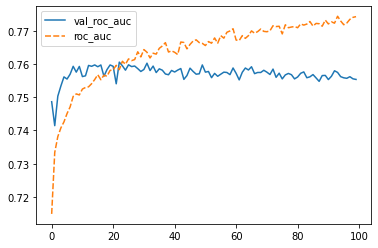

In [67]:
sns.lineplot(data=pd.DataFrame(best_neural_network.history.history)[['val_roc_auc', 'roc_auc']])

Can see that dev and train performance diverges around 20 epochs

In [69]:
history_df = pd.DataFrame(best_neural_network.history.history)
history_df.head()

,val_loss,val_roc_auc,loss,roc_auc
0,0.268359,0.748670,0.259050,0.714867
1,0.253892,0.741452,0.253621,0.733403
2,0.251589,0.750340,0.252394,0.738158
3,0.254618,0.753406,0.251796,0.740786
4,0.253778,0.756144,0.251360,0.742597


In [70]:
history_df['roc_auc_diff'] = np.abs(history_df['val_roc_auc'] - history_df['roc_auc'])

In [71]:
history_df[history_df['roc_auc_diff'] == history_df['roc_auc_diff'].min()]

,val_loss,val_roc_auc,loss,roc_auc,roc_auc_diff
17,0.249628,0.75634,0.247306,0.756661,0.000321


In [72]:
history_df[history_df['val_roc_auc'] == history_df['val_roc_auc'].max()]

,val_loss,val_roc_auc,loss,roc_auc,roc_auc_diff
22,0.251922,0.76059,0.246892,0.758331,0.002259


In [73]:
roc_auc_score(y_dev, best_neural_network.predict(X_dev))

0.7556442202910035

ROC AUC on dev set is worse after 100 epochs than after 20 epochs (-0.7605553369583515 in Bayes search). Let's retrain for 22 epochs:

In [74]:
simple_neural_network = SimpleNeuralNetwork(
    number_of_inputs=len(FINAL_FEATURES),
    number_of_layers=number_of_layers,
    neurons_per_layer=neurons_per_layer,
    dropout_rate_per_layer=dropout_rate_per_layer,
    learning_rate=learning_rate
)

In [75]:
best_neural_network = simple_neural_network.create_model()

In [76]:
best_neural_network.summary()

Model: "model_206"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_206 (InputLayer)       (None, 212)               0         
_________________________________________________________________
dropout_693 (Dropout)        (None, 212)               0         
_________________________________________________________________
dense_898 (Dense)            (None, 57)                12141     
_________________________________________________________________
batch_normalization_693 (Bat (None, 57)                228       
_________________________________________________________________
activation_693 (Activation)  (None, 57)                0         
_________________________________________________________________
dropout_694 (Dropout)        (None, 57)                0         
_________________________________________________________________
dense_899 (Dense)            (None, 57)                33

In [77]:
# Compile model
rocauc = keras.metrics.AUC(num_thresholds=200, curve='ROC', summation_method='interpolation', name='roc_auc')
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
best_neural_network.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[rocauc])

In [78]:
# Fit model
best_neural_network.fit(
    X_train,
    y_train,
    epochs=22,
    batch_size=batch_size,
    validation_data=(X_dev, y_dev)
)

Train on 184506 samples, validate on 61502 samples
Epoch 1/22
184506/184506 [==============================] - 8s 41us/step - loss: 0.2579 - roc_auc: 0.7185 - val_loss: 0.2573 - val_roc_auc: 0.7494
Epoch 2/22
184506/184506 [==============================] - 7s 38us/step - loss: 0.2536 - roc_auc: 0.7332 - val_loss: 0.2569 - val_roc_auc: 0.7436
Epoch 3/22
184506/184506 [==============================] - 7s 38us/step - loss: 0.2523 - roc_auc: 0.7380 - val_loss: 0.2625 - val_roc_auc: 0.7541
Epoch 4/22
184506/184506 [==============================] - 7s 38us/step - loss: 0.2518 - roc_auc: 0.7405 - val_loss: 0.2532 - val_roc_auc: 0.7546
Epoch 5/22
184506/184506 [==============================] - 7s 39us/step - loss: 0.2513 - roc_auc: 0.7429 - val_loss: 0.2528 - val_roc_auc: 0.7533
Epoch 6/22
184506/184506 [==============================] - 7s 39us/step - loss: 0.2509 - roc_auc: 0.7444 - val_loss: 0.2541 - val_roc_auc: 0.7546
Epoch 7/22
184506/184506 [==============================] - 7s 39us

In [79]:
roc_auc_score(y_dev, best_neural_network.predict(X_dev))

0.7594572063905445

### Submission - neural network

In [80]:
test_kaggle.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,POS_CASH_balance_SK_DPD_DEF_amax_sum_y,POS_CASH_balance_SK_DPD_DEF_amax_amin_y,POS_CASH_balance_SK_DPD_DEF_amax_amax_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Active_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Approved_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Completed_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Demand_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Refused,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Sent_proposal,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Signed_y
307511,100001,NaN,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307512,100005,NaN,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307513,100013,NaN,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458,...,1.0,1.0,1.0,96.0,0.0,0.0,0.0,0.0,0.0,0.0
307514,100028,NaN,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,-1866,...,0.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0
307515,100038,NaN,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,-2191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
test_kaggle_nn = test_kaggle.copy()[FINAL_FEATURES]

In [85]:
test_kaggle_nn[aggregated_features].fillna(0, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [86]:
test_kaggle_nn = mean_imputer.transform(test_kaggle_nn)

In [87]:
test_kaggle_nn = pd.DataFrame(test_kaggle_nn, columns=FINAL_FEATURES)

In [88]:
test_kaggle_nn = min_max_scalar.transform(test_kaggle_nn)

In [89]:
predictions_nn = best_neural_network.predict(test_kaggle_nn)

In [90]:
predictions_nn

array([[0.02748877],
       [0.14351025],
       [0.03602505],
       ...,
       [0.01290962],
       [0.05033246],
       [0.09119734]], dtype=float32)

In [91]:
submission_df_nn = test_kaggle.copy()[['SK_ID_CURR']]

In [93]:
submission_df_nn['TARGET'] = predictions_nn

In [94]:
submission_df_nn.head()

,SK_ID_CURR,TARGET
307511,100001,0.027489
307512,100005,0.143510
307513,100013,0.036025
307514,100028,0.029166
307515,100038,0.122628


In [95]:
submission_df_nn.to_csv('data/processed/best_nn_with_bayes.csv', index=False)

In [97]:
!kaggle competitions submit -c home-credit-default-risk -f data/processed/best_nn_with_bayes.csv -m "best_nn_with_bayes"

100%|█████████████████████████████████████████| 883k/883k [00:08<00:00, 108kB/s]
Successfully submitted to Home Credit Default Risk

Private score: 0.75906

Public score: 0.76020

This is the best neural network so far but still worse than the best LGBM. Suspect this is due to better treatment of nulls in LGBM. With more careful feature engineering the neural network may perform better.

### Submission - ensemble

Best perfoming lightgbm submission (random search):

In [99]:
submission_df_lgbm = pd.read_csv('data/processed/all_features_random_search_submission_trainanddev.csv')
submission_df_lgbm.head()

,SK_ID_CURR,TARGET
0,100001,0.069796
1,100005,0.120036
2,100013,0.032273
3,100028,0.030573
4,100038,0.128878


In [100]:
submission_df_lgbm.rename(columns={'TARGET': 'TARGET_LGBM'}, inplace=True)
submission_df_nn.rename(columns={'TARGET': 'TARGET_NN'}, inplace=True)

submission_df = submission_df_lgbm.merge(submission_df_nn, on='SK_ID_CURR')
submission_df.head()

,SK_ID_CURR,TARGET_LGBM,TARGET_NN
0,100001,0.069796,0.027489
1,100005,0.120036,0.143510
2,100013,0.032273,0.036025
3,100028,0.030573,0.029166
4,100038,0.128878,0.122628


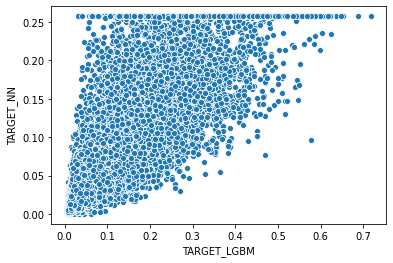

In [102]:
sns.scatterplot(x='TARGET_LGBM', y='TARGET_NN', data=submission_df)

In [103]:
submission_df_nn.max()

SK_ID_CURR    456250.000000
TARGET_NN          0.257304
dtype: float64

In [107]:
submission_df_nn[submission_df_nn['TARGET_NN'] == submission_df_nn['TARGET_NN'].max()].shape

(861, 2)

In [109]:
best_neural_network.predict(X_train).max()

0.2573042

In [111]:
X_train_df = pd.DataFrame(X_train, columns=FINAL_FEATURES)
X_train_df['predictions'] = best_neural_network.predict(X_train)

In [112]:
X_train_df.head()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,POS_CASH_balance_AMT_RECEIVABLE_PRINCIPAL_mean_mean,POS_CASH_balance_AMT_RECIVABLE_sum_amax,POS_CASH_balance_CNT_DRAWINGS_ATM_CURRENT_mean_mean,POS_CASH_balance_CNT_DRAWINGS_ATM_CURRENT_mean_sum,POS_CASH_balance_CNT_DRAWINGS_ATM_CURRENT_mean_amax,POS_CASH_balance_CNT_DRAWINGS_CURRENT_mean_mean,POS_CASH_balance_CNT_DRAWINGS_CURRENT_mean_sum,POS_CASH_balance_CNT_DRAWINGS_CURRENT_amax_mean,POS_CASH_balance_CNT_DRAWINGS_POS_CURRENT_mean_mean,predictions
0,0.003607,0.016854,0.016750,0.017957,0.257000,0.572266,0.026091,0.878160,0.998888,0.132241,...,0.001503,0.005968,0.016272,0.00000,0.016305,0.000000,0.000000,0.000000,0.014557,0.040344
1,0.014795,0.191011,0.150397,0.191919,0.491595,0.615445,0.041899,0.901520,0.278033,0.043956,...,0.078560,0.093224,0.016272,0.01144,0.016305,0.012833,0.012919,0.040772,0.014557,0.038992
2,0.014795,0.374787,0.158763,0.326599,0.446855,0.563303,0.031739,0.680432,0.375851,0.087912,...,0.001503,0.005968,0.016272,0.00000,0.016305,0.000000,0.000000,0.000000,0.014557,0.020362
3,0.013125,0.099730,0.110148,0.074074,0.257000,0.425085,0.044781,0.816066,0.827289,0.241758,...,0.001503,0.005968,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.087414
4,0.007447,0.292435,0.131609,0.254770,0.245631,0.631285,0.045788,0.854800,0.382104,0.132241,...,0.078560,0.093224,0.016272,0.01144,0.016305,0.012833,0.012919,0.040772,0.014557,0.051058


In [113]:
X_train_df[X_train_df['predictions'] == X_train_df['predictions'].max()]

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,POS_CASH_balance_AMT_RECEIVABLE_PRINCIPAL_mean_mean,POS_CASH_balance_AMT_RECIVABLE_sum_amax,POS_CASH_balance_CNT_DRAWINGS_ATM_CURRENT_mean_mean,POS_CASH_balance_CNT_DRAWINGS_ATM_CURRENT_mean_sum,POS_CASH_balance_CNT_DRAWINGS_ATM_CURRENT_mean_amax,POS_CASH_balance_CNT_DRAWINGS_CURRENT_mean_mean,POS_CASH_balance_CNT_DRAWINGS_CURRENT_mean_sum,POS_CASH_balance_CNT_DRAWINGS_CURRENT_amax_mean,POS_CASH_balance_CNT_DRAWINGS_POS_CURRENT_mean_mean,predictions
22,0.006446,0.100638,0.077826,0.068462,0.276330,0.882300,0.042328,0.882046,0.685286,0.132241,...,0.078560,0.093224,0.016272,0.011440,0.016305,0.012833,0.012919,0.040772,0.014557,0.257304
136,0.003774,0.029146,0.043360,0.023569,0.276330,0.882469,0.046206,0.849376,0.940670,0.142857,...,0.078560,0.093224,0.016272,0.011440,0.016305,0.012833,0.012919,0.040772,0.014557,0.257304
150,0.007447,0.022472,0.033869,0.023569,0.093190,0.711669,0.045379,0.713273,0.674170,0.132241,...,0.078560,0.093224,0.016272,0.011440,0.016305,0.012833,0.012919,0.040772,0.014557,0.257304
172,0.003774,0.043456,0.047385,0.038159,0.094492,0.964656,0.044679,0.873463,0.894123,0.132241,...,0.078560,0.093224,0.016272,0.011440,0.016305,0.012833,0.012919,0.040772,0.014557,0.257304
263,0.003106,0.012719,0.032480,0.012346,0.491595,0.902649,0.045921,0.894687,0.869668,0.132241,...,0.078560,0.093224,0.016272,0.011440,0.016305,0.012833,0.012919,0.040772,0.014557,0.257304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184460,0.004776,0.044944,0.050935,0.046016,0.107023,0.658286,0.042341,0.755680,0.501598,0.132241,...,0.078560,0.093224,0.016272,0.011440,0.016305,0.012833,0.012919,0.040772,0.014557,0.257304
184470,0.004776,0.129211,0.085806,0.103255,0.421848,0.584893,0.041633,0.983174,0.402946,0.132241,...,0.070191,0.248228,0.010030,0.010030,0.010030,0.003149,0.003149,0.042424,0.000180,0.257304
184477,0.005778,0.262427,0.224954,0.214366,0.245631,0.599098,0.038942,0.969423,0.940531,0.132241,...,0.078560,0.093224,0.016272,0.011440,0.016305,0.012833,0.012919,0.040772,0.014557,0.257304
184479,0.013125,0.044944,0.096509,0.046016,0.141377,0.929369,0.044154,0.626879,0.814923,0.010989,...,0.078560,0.093224,0.016272,0.011440,0.016305,0.012833,0.012919,0.040772,0.014557,0.257304


Not immediately clear why values are capped for a large number of predictions. Need to investigate further.

In [117]:
submission_df.head()

,SK_ID_CURR,TARGET_LGBM,TARGET_NN
0,100001,0.069796,0.027489
1,100005,0.120036,0.143510
2,100013,0.032273,0.036025
3,100028,0.030573,0.029166
4,100038,0.128878,0.122628


In [123]:
submission_df['TARGET'] = np.mean((submission_df['TARGET_LGBM'], submission_df['TARGET_NN']), axis=0)

In [125]:
submission_df[['SK_ID_CURR', 'TARGET']].to_csv('data/processed/nn_lgbm_ensemble.csv', index=False)

In [126]:
!kaggle competitions submit -c home-credit-default-risk -f data/processed/nn_lgbm_ensemble.csv -m "nn_lgbm_ensemble"

100%|███████████████████████████████████████| 1.27M/1.27M [00:07<00:00, 169kB/s]
Successfully submitted to Home Credit Default Risk

Private score: 0.77640

Public score: 0.77651

Best public score so far, private score less than random search lightgbm.

### Save model

In [157]:
best_neural_network.save('models/best_neural_network.h5')

In [179]:
# Reload model (we load weights rather than the entire model because load_model leads to errors with the custom AUC)

# test_model = SimpleNeuralNetwork(
#     number_of_inputs=212,
#     number_of_layers=3,
#     neurons_per_layer=57,
#     dropout_rate_per_layer=0.03752158001340439,
#     learning_rate=0.06627387542238576
# ).create_model()

# test_model.summary()

# test_model.load_weights('models/best_neural_network.h5')

In [181]:
best_neural_network_preprocessing = {
    'aggregated_features_fillna_zeros': aggregated_features,
    'mean_imputer': mean_imputer,
    'min_max_scalar': min_max_scalar
}

In [182]:
pickle.dump(best_neural_network_preprocessing, open('models/best_neural_network_preprocessing.pickle', 'wb'))

In [183]:
# temp = pickle.load(open('models/best_neural_network_preprocessing.pickle', 'rb'))